In [ ]:
from google.colab import files
 
uploaded = files.upload()
 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

KeyboardInterrupt: ignored

In [ ]:
!kaggle datasets download -d "tunguz/xview2-challenge-dataset-train-and-test"

100% 10.3G/10.3G [03:59<00:00, 37.0MB/s]
100% 10.3G/10.3G [03:59<00:00, 46.4MB/s]


In [ ]:
!unzip xview2-challenge-dataset-train-and-test.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/labels/hurricane-florence_00000481_post_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000481_pre_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000482_post_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000482_pre_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000484_post_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000484_pre_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000485_post_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000485_pre_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000486_post_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000486_pre_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000490_post_disaster.json  
  inflating: train/train/labels/hurricane-florence_00000490_pre

In [ ]:
# Fetch all post disaster json files
from pathlib import Path
labels_generator = Path('/content/train').rglob(pattern=f'*post_*.json')

In [ ]:
#importing all libraries
from PIL import Image
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import math
import random
import argparse
import logging
import json
import cv2
import datetime

import shapely.wkt
import shapely
from shapely.geometry import Polygon
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [ ]:
#damage intensity encoding

damage_intensity_encoding = defaultdict(lambda: 0)
damage_intensity_encoding['destroyed'] = 3
damage_intensity_encoding['major-damage'] = 2
damage_intensity_encoding['minor-damage'] = 1
damage_intensity_encoding['no-damage'] = 0


In [ ]:
#path to images and labels
input_path = '/content/train/train'

In [ ]:
#processing images to  extract buildings polygons

def process_img(img_array, polygon_pts, scale_pct):
    """Process Raw Data into
            Args:
                img_array (numpy array): numpy representation of image.
                polygon_pts (array): corners of the building polygon.
            Returns:
                numpy array: .
    """

    height, width, _ = img_array.shape

    xcoords = polygon_pts[:, 0]
    ycoords = polygon_pts[:, 1]
    xmin, xmax = np.min(xcoords), np.max(xcoords)
    ymin, ymax = np.min(ycoords), np.max(ycoords)

    xdiff = xmax - xmin
    ydiff = ymax - ymin

    #Extend image by scale percentage
    xmin = max(int(xmin - (xdiff * scale_pct)), 0)
    xmax = min(int(xmax + (xdiff * scale_pct)), width)
    ymin = max(int(ymin - (ydiff * scale_pct)), 0)
    ymax = min(int(ymax + (ydiff * scale_pct)), height)

    return img_array[ymin:ymax, xmin:xmax, :]



In [ ]:
#process data to obtain a dataset
def process_data(input_path, output_path, output_path_csv):
    """Process Raw Data into
        Args:
            dir_path (path): Path to the xBD dataset.
            
        Returns:
            x_data: A list of numpy arrays representing the images for training
            y_data: A list of labels for damage represented in matrix form
    """
    x_data = []
    y_data = []

    disaster_path = input_path + "/"  + "images"
    image_paths = []
    image_paths.extend([(disaster_path + "/" + pic) for pic in os.listdir(disaster_path)])
    img_paths = np.array(image_paths)
    img_paths = img_paths


    for img_path in tqdm(img_paths):

        img_obj = Image.open(img_path)
        img_array = np.array(img_obj)

        #Get corresponding label for the current image
        label_path = img_path.replace('png', 'json').replace('images', 'labels')
        label_file = open(label_path)
        label_data = json.load(label_file)

        for feat in label_data['features']['xy']:
        

            # only images post-disaster will have damage type
            try:
                damage_type = feat['properties']['subtype']
            except: # pre-disaster damage is default no-damage
                damage_type = "no-damage"
                continue

            poly_uuid = feat['properties']['uid'] + ".png"
        

            y_data.append(damage_intensity_encoding[damage_type])
          

            polygon_geom = shapely.wkt.loads(feat['wkt'])
            polygon_pts = np.array(list(polygon_geom.exterior.coords))
            poly_img = process_img(img_array, polygon_pts, 0.8)
            

            

            cv2.imwrite(output_path + "/" + poly_uuid, poly_img)
            x_data.append(poly_uuid)
    output_path_csv = os.path.join(output_path_csv, "train.csv")
    data_array = {'uuid': x_data, 'labels': y_data}
    df = pd.DataFrame(data = data_array)
    df.to_csv(output_path_csv)

      


    

Note that, you have to create a proc_images and proc_data inside the train folder before calling the process_data function so that the images and csv images can be stored. 

In [ ]:
pimage = '/content/train/train/proc_images'       #folder path to save images please create it first as colab deletes
p_data = '/content/train/train/proc_data'        #folder path to save csv of labels please create it first as colab deletes  
process_data(input_path, pimage, p_data)



100%|██████████| 5598/5598 [06:54<00:00, 13.52it/s]


In [ ]:
#reading the data csv file
df = pd.read_csv('/content/train/train/proc_data/train.csv')

In [ ]:
df = df.drop(df.columns[0], axis = 1)

In [ ]:
df_random = df   

In [ ]:
df_random.reset_index(inplace=True)

In [ ]:
df_random.labels.value_counts()

0    120419
1     14980
2     14161
3     13227
Name: labels, dtype: int64

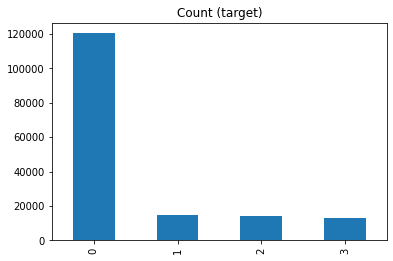

In [ ]:
df_random.labels.value_counts().plot(kind='bar', title='Count (target)');
#from the bar plot its visible that the number of samples containing label1 is very high thereby leading to an imbalanced dataset

In [ ]:
#image processing to flatten the images or to convert the rgb(3d numpy) into a 1d numpy array
import cv2 
import matplotlib.pyplot as plt
import numpy as np
image = list()
for i in tqdm(df_random.uuid):
  path = '/content/train/train/proc_images/'+i
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  scaled_image = cv2.resize(img, (50, 50))
  image.append(scaled_image.flatten())


100%|██████████| 162787/162787 [01:26<00:00, 1881.48it/s]


In [ ]:
image = np.array(image)     #converting the list containing images arrays into a numpy array
image.shape

(162787, 2500)

In [ ]:
image = np.array(image)

In [ ]:
y = df_random.labels     #getting only labels from df and saving it in y

In [ ]:
#importing train_test_split to split the datset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(image,y,test_size=0.20,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier  #importing randomforest classifer

In [ ]:
#importing cross_val_predict and fitting the data to model
from sklearn.model_selection import cross_val_predict
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train,
                                    y_train, cv=3,
                                    method="predict")

In [ ]:
#importing classification_report to print f_score
from sklearn.metrics import classification_report

print(classification_report(y_train, y_probas_forest, target_names=['no-damage', 'minor-damage', 'major-damage','destroyed'], digits=5))

              precision    recall  f1-score   support

   no-damage    0.74244   0.99814   0.85151     96284
minor-damage    0.29825   0.00142   0.00282     11990
major-damage    0.69792   0.01179   0.02319     11365
   destroyed    0.78731   0.03985   0.07586     10590

    accuracy                        0.74237    130229
   macro avg    0.63148   0.26280   0.23835    130229
weighted avg    0.70131   0.74237   0.63801    130229



In [ ]:
#xgboost model

In [ ]:
#importing the xgbclassifier
from xgboost import XGBClassifier
xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=150,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    nthread=4,
    scale_pos_weight=1,
    seed=27,
    num_class=4,
    )

In [ ]:
xgb1.fit(X_train[:30000], y_train[:30000])


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=4, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, silent=None, subsample=0.8, verbosity=1)

In [ ]:
y_pred = xgb1.predict(X_test)     

In [ ]:
#printing the f1 scores of XGB model

print(classification_report(y_test, y_pred, target_names=['no-damage', 'minor-damage', 'major-damage','destroyed'], digits=5))


              precision    recall  f1-score   support

   no-damage    0.74167   0.99925   0.85141     24135
minor-damage    0.35000   0.00234   0.00465      2990
major-damage    0.70000   0.00250   0.00499      2796
   destroyed    0.45455   0.00190   0.00378      2637

    accuracy                        0.74132     32558
   macro avg    0.56155   0.25150   0.21621     32558
weighted avg    0.67887   0.74132   0.63230     32558

